# 🎭 Treinamento de Classificador de Emoções com RAVDESS

## Dataset: Ryerson Audio-Visual Database of Emotional Speech and Song

Este notebook implementa um pipeline completo de treinamento para reconhecimento de emoções em áudio usando:
- **Features acústicas tradicionais** (MFCCs, Pitch, Energia, etc.)
- **Modelos de Machine Learning** (SVM ou Random Forest)
- **Dataset RAVDESS Speech** (24 atores, 8 emoções)

---

### 📋 Índice:
1. Configurações e Imports
2. Funções para Processar RAVDESS
3. Carregamento do Dataset
4. Extração de Features
5. Treinamento do Modelo
6. Avaliação e Visualizações
7. Salvamento do Modelo

---

## 1️⃣ Configurações e Imports

### Bibliotecas Utilizadas:
- **librosa**: Processamento de áudio e extração de features
- **scikit-learn**: Modelos de ML e métricas
- **matplotlib/seaborn**: Visualizações
- **numpy**: Operações numéricas
- **pickle**: Salvamento de objetos Python

In [ ]:
# !pip install librosa scikit-learn matplotlib seaborn numpy pickle

In [ ]:
# !wget -O Audio_Speech_Actors_01-24.zip "https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [ ]:
import zipfile
import os

# Caminho do arquivo zip
arquivo_zip = './Audio_Speech_Actors_01-24.zip'

# Diretório de destino
diretorio_destino = './ravdess'

# Criar o diretório de destino se não existir
os.makedirs(diretorio_destino, exist_ok=True)

# Extrair o arquivo
with zipfile.ZipFile(arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)

print(f"Arquivo extraído para: {diretorio_destino}")

# Excluir o arquivo zip
os.remove(arquivo_zip)
print(f"Arquivo {arquivo_zip} excluído com sucesso")

In [ ]:
# Imports necessários
import os
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Importar funções do classificador base
from emotion_classifier import extract_features, EmotionClassifier

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


### ⚙️ Configurações do Experimento

Ajuste estas variáveis de acordo com sua necessidade:

In [2]:
# ============================================
# CONFIGURAÇÕES - AJUSTE AQUI!
# ============================================

# 📂 Caminho para a pasta do RAVDESS extraído
RAVDESS_PATH = './ravdess/'  # ← Ajuste para seu caminho!

# 🎭 Emoções para treinar
# Opção 1 (recomendado para começar): 4 emoções principais
EMOTIONS_TO_USE = ['feliz', 'triste', 'raiva', 'neutro']

# Opção 2: Todas as 8 emoções disponíveis
# EMOTIONS_TO_USE = ['neutro', 'calmo', 'feliz', 'triste', 'raiva', 'medo', 'nojo', 'surpresa']

# 🤖 Modelo a usar
MODEL_TYPE = 'svm'  # 'svm' ou 'rf' (Random Forest)

print("⚙️ Configurações carregadas:")
print(f"   Pasta RAVDESS: {RAVDESS_PATH}")
print(f"   Emoções: {EMOTIONS_TO_USE}")
print(f"   Modelo: {MODEL_TYPE.upper()}")

⚙️ Configurações carregadas:
   Pasta RAVDESS: ./ravdess/
   Emoções: ['feliz', 'triste', 'raiva', 'neutro']
   Modelo: SVM


---

## 2️⃣ Funções para Processar RAVDESS

### 📝 Estrutura do Nome dos Arquivos RAVDESS

Os arquivos do RAVDESS seguem este padrão:
```
03-01-06-01-02-01-12.wav
│  │  │  │  │  │  └─ Actor ID (01-24)
│  │  │  │  │  └──── Repetição (01 ou 02)
│  │  │  │  └─────── Frase (01: "Kids...", 02: "Dogs...")
│  │  │  └────────── Intensidade (01: normal, 02: forte)
│  │  └───────────── Emoção (ver tabela)
│  └──────────────── Canal vocal (01: speech)
└─────────────────── Modalidade (03: apenas áudio)
```

### 🎭 Código das Emoções:
- 01 = neutro
- 02 = calmo
- 03 = feliz
- 04 = triste
- 05 = raiva
- 06 = medo
- 07 = nojo
- 08 = surpresa

In [4]:
def parse_ravdess_filename(filename):
    """
    Decodifica o nome do arquivo RAVDESS e extrai metadados.
    
    Parâmetros:
    -----------
    filename : str
        Nome do arquivo no formato RAVDESS (ex: '03-01-06-01-02-01-12.wav')
    
    Retorna:
    --------
    dict : Dicionário com informações do arquivo:
        - emotion: nome da emoção (ex: 'feliz', 'triste')
        - intensity: 'normal' ou 'forte'
        - statement: frase falada
        - repetition: número da repetição (1 ou 2)
        - actor: ID do ator (1-24)
        - gender: 'masculino' (ímpar) ou 'feminino' (par)
    
    Exemplo:
    --------
    >>> parse_ravdess_filename('03-01-05-02-01-01-12.wav')
    {'emotion': 'raiva', 'intensity': 'forte', 'actor': 12, 'gender': 'feminino', ...}
    """
    # Remover extensão e dividir por hífen
    parts = filename.replace('.wav', '').split('-')
    
    # Mapeamento de códigos para emoções
    emotion_map = {
        '01': 'neutro',
        '02': 'calmo', 
        '03': 'feliz',
        '04': 'triste',
        '05': 'raiva',
        '06': 'medo',
        '07': 'nojo',
        '08': 'surpresa'
    }
    
    # Mapeamento de intensidade
    intensity_map = {
        '01': 'normal',
        '02': 'forte'
    }
    
    # Mapeamento de frases
    statement_map = {
        '01': 'Kids are talking by the door',
        '02': 'Dogs are sitting by the door'
    }
    
    try:
        # Extrair informações das partes
        emotion_code = parts[2]      # Terceira posição: emoção
        intensity_code = parts[3]    # Quarta posição: intensidade
        statement_code = parts[4]    # Quinta posição: frase
        repetition = parts[5]        # Sexta posição: repetição
        actor_id = int(parts[6])     # Sétima posição: ator
        
        return {
            'emotion': emotion_map.get(emotion_code, 'desconhecido'),
            'intensity': intensity_map.get(intensity_code, 'normal'),
            'statement': statement_map.get(statement_code, ''),
            'repetition': int(repetition),
            'actor': actor_id,
            'gender': 'masculino' if actor_id % 2 == 1 else 'feminino'
        }
    except:
        # Retornar None se houver erro no parsing
        return None

# Teste da função
example = parse_ravdess_filename('03-01-05-02-01-01-12.wav')
print("\n📝 Exemplo de parsing:")
print(f"   Arquivo: 03-01-05-02-01-01-12.wav")
print(f"   Emoção: {example['emotion']}")
print(f"   Intensidade: {example['intensity']}")
print(f"   Ator: {example['actor']} ({example['gender']})")


📝 Exemplo de parsing:
   Arquivo: 03-01-05-02-01-01-12.wav
   Emoção: raiva
   Intensidade: forte
   Ator: 12 (feminino)


---

## 3️⃣ Carregamento do Dataset

### Função `load_ravdess_dataset()`

Esta função:
1. 📂 Percorre todas as pastas de atores (Actor_01 a Actor_24)
2. 🎵 Filtra apenas arquivos de Speech (começam com '03-01')
3. 🎭 Seleciona apenas as emoções desejadas
4. 📊 Retorna listas de arquivos, labels e metadados

### Estrutura Esperada:
```
RAVDESS/
├── Actor_01/
│   ├── 03-01-01-01-01-01-01.wav
│   ├── 03-01-01-01-01-02-01.wav
│   └── ...
├── Actor_02/
└── Actor_24/
```

In [5]:
def load_ravdess_dataset(ravdess_path, emotions_to_use):
    """
    Carrega arquivos de áudio do dataset RAVDESS Speech.
    
    Parâmetros:
    -----------
    ravdess_path : str
        Caminho para a pasta raiz do RAVDESS (contém Actor_01, Actor_02, etc.)
    emotions_to_use : list
        Lista de emoções para incluir (ex: ['feliz', 'triste', 'raiva', 'neutro'])
    
    Retorna:
    --------
    audio_files : list
        Lista com caminhos completos dos arquivos de áudio
    labels : list
        Lista com as emoções correspondentes
    metadata : list
        Lista com dicionários contendo informações extras (ator, gênero, etc.)
    
    Exemplo de uso:
    ---------------
    >>> files, labels, meta = load_ravdess_dataset('RAVDESS/', ['feliz', 'triste'])
    >>> print(f"Carregados {len(files)} arquivos")
    """
    audio_files = []
    labels = []
    metadata = []
    
    print("="*60)
    print("📂 CARREGANDO DATASET RAVDESS")
    print("="*60)
    print(f"Pasta: {ravdess_path}")
    print(f"Emoções selecionadas: {emotions_to_use}")
    print()
    
    # Verificar se a pasta existe
    if not os.path.exists(ravdess_path):
        print(f"❌ ERRO: Pasta não encontrada: {ravdess_path}")
        print("   Ajuste o caminho RAVDESS_PATH no início do notebook!")
        return [], [], []
    
    # Listar pastas de atores (Actor_01, Actor_02, ...)
    actor_folders = sorted([d for d in os.listdir(ravdess_path) 
                           if os.path.isdir(os.path.join(ravdess_path, d)) 
                           and d.startswith('Actor_')])
    
    if not actor_folders:
        print(f"❌ ERRO: Nenhuma pasta de ator encontrada!")
        print("   Estrutura esperada: RAVDESS/Actor_01/, Actor_02/, etc.")
        return [], [], []
    
    print(f"✅ Encontradas {len(actor_folders)} pastas de atores")
    print()
    
    # Processar cada pasta de ator
    for actor_folder in actor_folders:
        actor_path = os.path.join(ravdess_path, actor_folder)
        
        # Processar cada arquivo de áudio na pasta do ator
        for filename in os.listdir(actor_path):
            # Filtrar apenas arquivos de Speech (começam com 03-01)
            if filename.endswith('.wav') and filename.startswith('03-01'):
                filepath = os.path.join(actor_path, filename)
                info = parse_ravdess_filename(filename)
                
                # Adicionar apenas se a emoção estiver na lista desejada
                if info and info['emotion'] in emotions_to_use:
                    audio_files.append(filepath)
                    labels.append(info['emotion'])
                    metadata.append(info)
    
    print(f"✅ Total de arquivos carregados: {len(audio_files)}")
    print()
    
    # Mostrar distribuição das emoções
    distribution = Counter(labels)
    print("📊 DISTRIBUIÇÃO DAS EMOÇÕES:")
    print("-" * 40)
    for emotion in sorted(emotions_to_use):
        count = distribution.get(emotion, 0)
        bar = '█' * (count // 5)  # Barra de visualização
        print(f"   {emotion:10s}: {count:3d} arquivos {bar}")
    print()
    
    # Mostrar distribuição por gênero
    gender_dist = Counter([m['gender'] for m in metadata])
    print("👥 DISTRIBUIÇÃO POR GÊNERO:")
    print("-" * 40)
    for gender, count in gender_dist.items():
        print(f"   {gender}: {count} arquivos")
    print()
    
    return audio_files, labels, metadata

### 🚀 Executar Carregamento

Agora vamos carregar os dados:

In [6]:
# Carregar dataset
audio_files, labels, metadata = load_ravdess_dataset(RAVDESS_PATH, EMOTIONS_TO_USE)

if not audio_files:
    print("❌ Nenhum arquivo carregado. Verifique o caminho RAVDESS_PATH!")
else:
    print(f"✅ Pronto para processar {len(audio_files)} arquivos!")

📂 CARREGANDO DATASET RAVDESS
Pasta: ./ravdess/
Emoções selecionadas: ['feliz', 'triste', 'raiva', 'neutro']

✅ Encontradas 24 pastas de atores

✅ Total de arquivos carregados: 672

📊 DISTRIBUIÇÃO DAS EMOÇÕES:
----------------------------------------
   feliz     : 192 arquivos ██████████████████████████████████████
   neutro    :  96 arquivos ███████████████████
   raiva     : 192 arquivos ██████████████████████████████████████
   triste    : 192 arquivos ██████████████████████████████████████

👥 DISTRIBUIÇÃO POR GÊNERO:
----------------------------------------
   masculino: 336 arquivos
   feminino: 336 arquivos

✅ Pronto para processar 672 arquivos!


---

## 4️⃣ Extração de Features

### O que são Features Acústicas?

Features são características numéricas extraídas do áudio que capturam diferentes aspectos do som:

| Feature | O que mede | Por que é importante |
|---------|------------|----------------------|
| **MFCCs** | Textura do som | Diferencia timbres de voz |
| **Pitch** | Tom da voz | Raiva = alto, Triste = baixo |
| **Energia** | Intensidade | Raiva = alta, Triste = baixa |
| **ZCR** | Mudança de sinal | Detecta fricativas e sibilantes |
| **Chroma** | Informação tonal | Características melódicas |
| **Spectral Contrast** | Picos vs vales | Textura do espectro |

### Processo de Extração:

Para cada áudio de ~3 segundos, extraímos **62 features numéricas**:
- 26 features de MFCCs (média e desvio padrão)
- 24 features de Chroma
- 7 features de Spectral Contrast
- 5 features extras (ZCR, RMS, Pitch)

### Função `extract_and_save_features()`

Esta função:
1. 🎵 Processa cada áudio usando `extract_features()` do módulo base
2. 📊 Cria matriz X (amostras × features) e vetor y (labels)
3. 💾 Salva em arquivo .pkl para reutilizar depois
4. ⏱️ **Tempo estimado:** ~10-15 minutos para 400 arquivos

In [7]:
def extract_and_save_features(audio_files, labels, save_path='ravdess_features.pkl'):
    """
    Extrai features acústicas de todos os áudios e salva em arquivo.
    
    Este é o passo mais DEMORADO do pipeline (pode levar 10-15 minutos).
    Os features são salvos em arquivo para que não seja necessário
    reprocessar tudo nas próximas execuções.
    
    Parâmetros:
    -----------
    audio_files : list
        Lista de caminhos para os arquivos de áudio
    labels : list
        Lista de emoções correspondentes
    save_path : str
        Caminho onde salvar o arquivo com features extraídas
    
    Retorna:
    --------
    X : numpy.ndarray
        Matriz de features (n_amostras, n_features)
    y : numpy.ndarray
        Vetor de labels (n_amostras,)
    
    Formato do arquivo salvo:
    -------------------------
    {
        'X': array de features,
        'y': array de labels,
        'feature_shape': dimensões da matriz
    }
    """
    print("="*60)
    print("🎵 EXTRAINDO FEATURES DOS ÁUDIOS")
    print("="*60)
    print("⏳ Isso pode demorar alguns minutos...")
    print(f"   Total de arquivos: {len(audio_files)}")
    print()
    
    X = []  # Matriz de features
    y = []  # Vetor de labels
    failed = []  # Arquivos que falharam
    
    # Processar cada arquivo
    for i, (audio_file, label) in enumerate(zip(audio_files, labels), 1):
        try:
            # Extrair features usando função do módulo base
            # Esta função retorna um array de ~62 números
            features = extract_features(audio_file)
            X.append(features)
            y.append(label)
            
            # Mostrar progresso a cada 50 arquivos
            if i % 50 == 0:
                percentage = (i / len(audio_files)) * 100
                print(f"   Processados: {i}/{len(audio_files)} ({percentage:.1f}%)")
        
        except Exception as e:
            # Registrar falhas (normalmente não deve acontecer)
            error_msg = str(e)[:50]  # Limitar tamanho da mensagem
            print(f"   ⚠️  Erro no arquivo {os.path.basename(audio_file)}: {error_msg}")
            failed.append(audio_file)
    
    # Converter para arrays numpy
    X = np.array(X)
    y = np.array(y)
    
    # Mostrar estatísticas finais
    print()
    print(f"✅ Extração concluída!")
    print(f"   Sucessos: {len(X)}/{len(audio_files)}")
    if failed:
        print(f"   Falhas: {len(failed)}")
    print(f"   Shape das features: {X.shape}")
    print(f"   → {X.shape[0]} amostras × {X.shape[1]} features")
    print()
    
    # Salvar em arquivo pickle para reutilização
    print(f"💾 Salvando features em: {save_path}")
    with open(save_path, 'wb') as f:
        pickle.dump({
            'X': X,
            'y': y,
            'feature_shape': X.shape
        }, f)
    print(f"✅ Features salvas! (Use para evitar reprocessar nas próximas vezes)")
    print()
    
    return X, y


def load_saved_features(save_path='ravdess_features.pkl'):
    """
    Carrega features já extraídas anteriormente.
    
    Parâmetros:
    -----------
    save_path : str
        Caminho do arquivo com features salvas
    
    Retorna:
    --------
    X : numpy.ndarray
        Matriz de features
    y : numpy.ndarray
        Vetor de labels
    """
    print(f"📂 Carregando features salvas de: {save_path}")
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    print(f"✅ Features carregadas! Shape: {data['X'].shape}")
    print()
    return data['X'], data['y']

### 🚀 Executar Extração de Features

**Atenção:** Esta célula pode demorar 10-15 minutos na primeira execução!

In [8]:
# Nome do arquivo para salvar features
features_file = 'ravdess_features.pkl'

# Verificar se já existe arquivo de features salvo
if os.path.exists(features_file):
    print("📂 Features já extraídas encontradas!")
    print()
    resposta = input("Deseja usar as features salvas? (s/n): ").lower()
    
    if resposta == 's':
        # Carregar features salvas (rápido!)
        X, y = load_saved_features(features_file)
    else:
        # Reprocessar tudo
        print("\n🔄 Reprocessando arquivos...")
        X, y = extract_and_save_features(audio_files, labels, features_file)
else:
    # Primeira vez - processar tudo
    X, y = extract_and_save_features(audio_files, labels, features_file)

print(f"✅ Pronto! Matriz de features: {X.shape}")

🎵 EXTRAINDO FEATURES DOS ÁUDIOS
⏳ Isso pode demorar alguns minutos...
   Total de arquivos: 672

   Processados: 50/672 (7.4%)
   Processados: 100/672 (14.9%)
   Processados: 150/672 (22.3%)
   Processados: 200/672 (29.8%)
   Processados: 250/672 (37.2%)
   Processados: 300/672 (44.6%)
   Processados: 350/672 (52.1%)
   Processados: 400/672 (59.5%)
   Processados: 450/672 (67.0%)
   Processados: 500/672 (74.4%)
   Processados: 550/672 (81.8%)
   Processados: 600/672 (89.3%)
   Processados: 650/672 (96.7%)

✅ Extração concluída!
   Sucessos: 672/672
   Shape das features: (672, 62)
   → 672 amostras × 62 features

💾 Salvando features em: ravdess_features.pkl
✅ Features salvas! (Use para evitar reprocessar nas próximas vezes)

✅ Pronto! Matriz de features: (672, 62)


---

## 5️⃣ Treinamento do Modelo

### Divisão Treino/Teste

- **80% dos dados** → Treinamento (modelo aprende)
- **20% dos dados** → Teste (modelo nunca viu, avalia generalização)
- **Stratify**: mantém proporção de classes em ambos os conjuntos

### Modelos Disponíveis:

**1. SVM (Support Vector Machine):**
- Encontra hiperplano ótimo para separar classes
- Kernel RBF permite fronteiras não-lineares
- Bom com features de alta dimensão
- Geralmente melhor acurácia para este problema

**2. Random Forest:**
- Ensemble de árvores de decisão
- Mais interpretável (mostra importância de features)
- Robusto a overfitting
- Bom baseline

In [9]:
def train_and_evaluate(X, y, model_type='svm'):
    """
    Treina e avalia o modelo de classificação de emoções.
    
    Pipeline completo:
    1. Divide dados em treino (80%) e teste (20%)
    2. Normaliza features com StandardScaler
    3. Treina o modelo escolhido (SVM ou Random Forest)
    4. Avalia no conjunto de teste
    5. Mostra métricas detalhadas
    
    Parâmetros:
    -----------
    X : numpy.ndarray
        Matriz de features (n_amostras, n_features)
    y : numpy.ndarray
        Vetor de labels (n_amostras,)
    model_type : str
        Tipo de modelo: 'svm' ou 'rf' (Random Forest)
    
    Retorna:
    --------
    classifier : EmotionClassifier
        Modelo treinado
    X_test : numpy.ndarray
        Features do conjunto de teste
    y_test : numpy.ndarray
        Labels reais do teste
    y_pred : numpy.ndarray
        Labels preditas pelo modelo
    """
    print("="*60)
    print("🤖 TREINAMENTO DO MODELO")
    print("="*60)
    
    # Passo 1: Dividir em treino e teste
    # test_size=0.2 → 20% para teste
    # random_state=42 → resultados reproduzíveis
    # stratify=y → mantém proporção de classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    print(f"Modelo selecionado: {model_type.upper()}")
    print(f"Dados de treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Dados de teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")
    print()
    
    # Passo 2 e 3: Criar e treinar o modelo
    # EmotionClassifier cuida da normalização e treinamento
    print(f"Treinando modelo {model_type.upper()}...")
    classifier = EmotionClassifier(model_type=model_type)
    classifier.train(X_train, y_train)
    print()
    
    # Passo 4: Fazer predições no conjunto de teste
    print("="*60)
    print("📊 AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("="*60)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Passo 5: Mostrar métricas
    print(f"\n🎯 ACURÁCIA GERAL: {accuracy:.2%}")
    print()
    print("Relatório por classe:")
    print(classification_report(y_test, y_pred))
    
    return classifier, X_test, y_test, y_pred

### 🚀 Executar Treinamento

In [10]:
# Treinar o modelo
classifier, X_test, y_test, y_pred = train_and_evaluate(X, y, MODEL_TYPE)

🤖 TREINAMENTO DO MODELO
Modelo selecionado: SVM
Dados de treino: 537 amostras (79.9%)
Dados de teste: 135 amostras (20.1%)

Treinando modelo SVM...

Treinando modelo SVM...
Treinamento concluído!

📊 AVALIAÇÃO NO CONJUNTO DE TESTE

🎯 ACURÁCIA GERAL: 71.85%

Relatório por classe:
              precision    recall  f1-score   support

       feliz       0.69      0.82      0.75        38
      neutro       0.67      0.21      0.32        19
       raiva       0.92      0.85      0.88        39
      triste       0.60      0.74      0.67        39

    accuracy                           0.72       135
   macro avg       0.72      0.65      0.65       135
weighted avg       0.73      0.72      0.70       135



### 📊 Interpretação das Métricas

**Precision (Precisão):**
- Quando o modelo diz que é emoção X, quantas vezes está correto?
- Exemplo: Precision de 0.80 para "feliz" = 80% das predições "feliz" estão corretas

**Recall (Revocação):**
- De todas as emoções X verdadeiras, quantas o modelo detectou?
- Exemplo: Recall de 0.70 para "triste" = detectou 70% dos "triste" reais

**F1-Score:**
- Média harmônica de precision e recall
- Balanceia ambas as métricas
- Melhor métrica para classes desbalanceadas

**Support:**
- Número de amostras reais de cada classe no conjunto de teste

---

## 6️⃣ Visualizações dos Resultados

### Matriz de Confusão

Mostra onde o modelo acerta e erra:
- **Diagonal principal**: Acertos
- **Fora da diagonal**: Confusões
- Exemplo: Se muitos "neutro" são classificados como "calmo", haverá valor alto nessa posição

📈 MATRIZ DE CONFUSÃO

✅ Salva: ravdess_confusion_matrix.png


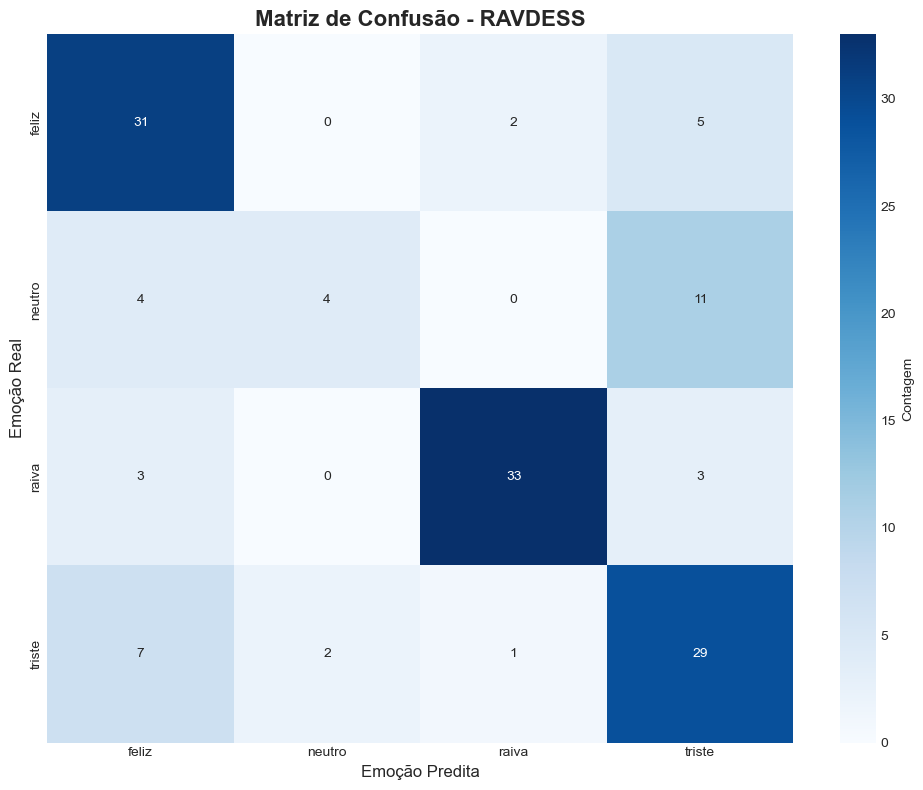

In [11]:
def plot_confusion_matrix(y_test, y_pred, emotions):
    """
    Cria e exibe matriz de confusão.
    
    A matriz de confusão mostra:
    - Linhas: Classes verdadeiras
    - Colunas: Classes preditas
    - Valores: Quantidade de predições
    
    Parâmetros:
    -----------
    y_test : array
        Labels verdadeiros do conjunto de teste
    y_pred : array
        Labels preditos pelo modelo
    emotions : list
        Lista de emoções (ordem das classes)
    """
    print("="*60)
    print("📈 MATRIZ DE CONFUSÃO")
    print("="*60)
    print()
    
    # Calcular matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=emotions)
    
    # Criar visualização
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions,
                cbar_kws={'label': 'Contagem'})
    plt.title('Matriz de Confusão - RAVDESS', fontsize=16, fontweight='bold')
    plt.ylabel('Emoção Real', fontsize=12)
    plt.xlabel('Emoção Predita', fontsize=12)
    plt.tight_layout()
    
    # Salvar figura
    plt.savefig('ravdess_confusion_matrix.png', dpi=150, bbox_inches='tight')
    print("✅ Salva: ravdess_confusion_matrix.png")
    
    plt.show()

# Gerar matriz de confusão
emotions = sorted(EMOTIONS_TO_USE)
plot_confusion_matrix(y_test, y_pred, emotions)

### Acurácia por Emoção

Mostra qual emoção o modelo classifica melhor:

📊 ACURÁCIA POR EMOÇÃO

   feliz     : 81.58%
   neutro    : 21.05%
   raiva     : 84.62%
   triste    : 74.36%

✅ Salva: ravdess_accuracy_per_emotion.png


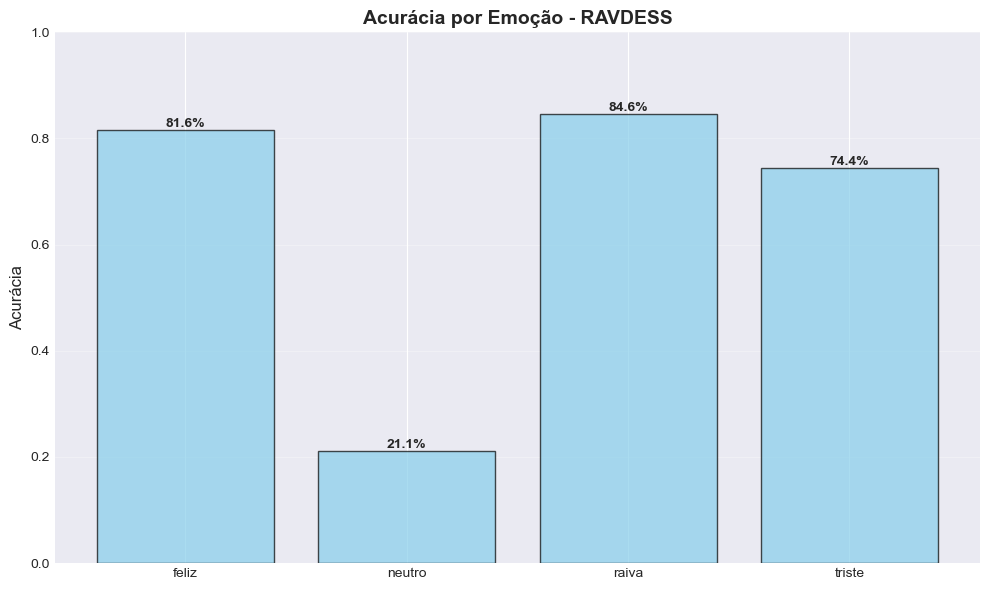

In [12]:
def plot_accuracy_per_emotion(y_test, y_pred, emotions):
    """
    Plota acurácia individual de cada emoção.
    
    Para cada emoção, calcula:
    Acurácia = (predições corretas) / (total de amostras dessa emoção)
    
    Parâmetros:
    -----------
    y_test : array
        Labels verdadeiros
    y_pred : array
        Labels preditos
    emotions : list
        Lista de emoções
    """
    print("="*60)
    print("📊 ACURÁCIA POR EMOÇÃO")
    print("="*60)
    print()
    
    # Calcular acurácia para cada emoção
    accuracies = []
    for emotion in emotions:
        # Filtrar apenas amostras dessa emoção
        mask = y_test == emotion
        if mask.sum() > 0:  # Se existem amostras
            acc = accuracy_score(y_test[mask], y_pred[mask])
            accuracies.append(acc)
            print(f"   {emotion:10s}: {acc:.2%}")
        else:
            accuracies.append(0)
    
    print()
    
    # Criar gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(emotions, accuracies, color='skyblue', 
                   edgecolor='black', alpha=0.7)
    
    plt.title('Acurácia por Emoção - RAVDESS', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Acurácia', fontsize=12)
    plt.ylim([0, 1])
    plt.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.1%}', ha='center', va='bottom', 
                fontweight='bold')
    
    plt.tight_layout()
    
    # Salvar figura
    plt.savefig('ravdess_accuracy_per_emotion.png', dpi=150, bbox_inches='tight')
    print("✅ Salva: ravdess_accuracy_per_emotion.png")
    
    plt.show()

# Gerar gráfico de acurácia
plot_accuracy_per_emotion(y_test, y_pred, emotions)

---

## 7️⃣ Salvamento do Modelo Treinado

Salvar o modelo permite usá-lo depois sem precisar treinar novamente:

In [13]:
# Nome do arquivo do modelo
model_file = f'emotion_model_{MODEL_TYPE}_ravdess.pkl'

# Salvar modelo treinado
print(f"💾 Salvando modelo treinado em: {model_file}")
with open(model_file, 'wb') as f:
    pickle.dump(classifier, f)
print(f"✅ Modelo salvo!")
print()

print("="*60)
print("✅ PROCESSO COMPLETO!")
print("="*60)
print(f"""
Arquivos gerados:
  - {features_file} (features extraídas)
  - {model_file} (modelo treinado)
  - ravdess_confusion_matrix.png
  - ravdess_accuracy_per_emotion.png

Próximos passos:
  1. Analise as visualizações acima
  2. Teste com diferentes emoções (edite EMOTIONS_TO_USE)
  3. Compare SVM vs Random Forest (edite MODEL_TYPE)
  4. Use o modelo para classificar novos áudios!
     Execute: python predict_with_model.py
""")

💾 Salvando modelo treinado em: emotion_model_svm_ravdess.pkl
✅ Modelo salvo!

✅ PROCESSO COMPLETO!

Arquivos gerados:
  - ravdess_features.pkl (features extraídas)
  - emotion_model_svm_ravdess.pkl (modelo treinado)
  - ravdess_confusion_matrix.png
  - ravdess_accuracy_per_emotion.png

Próximos passos:
  1. Analise as visualizações acima
  2. Teste com diferentes emoções (edite EMOTIONS_TO_USE)
  3. Compare SVM vs Random Forest (edite MODEL_TYPE)
  4. Use o modelo para classificar novos áudios!
     Execute: python predict_with_model.py



---

## 🧪 Testar com Novo Áudio (Opcional)

Use o modelo treinado para classificar um áudio novo:

In [ ]:
# Exemplo de teste com um arquivo do RAVDESS
# Descomente e ajuste o caminho:

# test_audio = 'RAVDESS/Actor_15/03-01-05-02-01-01-15.wav'  # Raiva
# 
# if os.path.exists(test_audio):
#     print(f"🎵 Testando com: {test_audio}")
#     
#     # Extrair features
#     features = extract_features(test_audio).reshape(1, -1)
#     
#     # Predizer
#     emotion = classifier.predict(features)[0]
#     probabilities = classifier.predict_proba(features)[0]
#     
#     print(f"\n🎯 Emoção detectada: {emotion.upper()}")
#     print(f"   Confiança: {probabilities.max():.1%}")
#     print()
#     print("📊 Todas as probabilidades:")
#     for emo, prob in zip(emotions, probabilities):
#         bar = '█' * int(prob * 50)
#         print(f"   {emo:10s}: {prob:6.1%} {bar}")

---

## 📚 Referências e Recursos

### Dataset RAVDESS:
```
Livingstone SR, Russo FA (2018)
The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS):
A dynamic, multimodal set of facial and vocal expressions in North American English.
PLoS ONE 13(5): e0196391.
https://doi.org/10.1371/journal.pone.0196391
```

### Bibliotecas:
- **librosa**: https://librosa.org/
- **scikit-learn**: https://scikit-learn.org/

### Próximos Passos:
1. Experimentar com diferentes conjuntos de emoções
2. Comparar desempenho de SVM vs Random Forest
3. Adicionar mais features (formantes, jitter, shimmer)
4. Testar com Deep Learning (CNNs, LSTMs)
5. Aplicar em dados reais (gravações próprias)

---

**Notebook criado para apresentação de trabalho acadêmico** 🎓